
# Fantasy Hockey Classification — Starter Notebook

This notebook builds two **classification** models using your multi-year fantasy hockey data:

1. **Skaters:** Predict whether a player will score **≥ 20 goals** (`is_20_goals`).
2. **Goalies:** Predict whether a goalie will have a **save% above the seasonal median** (`is_above_median_sv`).

We'll cover: loading, cleaning (including **deduplication**), EDA, feature engineering, model training, evaluation, and insights.


In [1]:

import os
import numpy as np
import pandas as pd
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             ConfusionMatrixDisplay, RocCurveDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 120)


## Sanity Check

In [11]:
import sys, pandas, sklearn
print(sys.version)
print("pandas:", pandas.__version__)
print("sklearn:", sklearn.__version__)


3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
pandas: 2.3.2
sklearn: 1.7.2


## Data paths

In [3]:
from pathlib import Path

# Start relative to the notebook
BASE_DIR = Path.cwd()
if BASE_DIR.name == "notebooks":
    BASE_DIR = BASE_DIR.parent

DATA_DIR = BASE_DIR / "data"

print("BASE_DIR:", BASE_DIR.resolve())
print("DATA_DIR:", DATA_DIR.resolve())
print("CSV files I see:", [p.name for p in DATA_DIR.glob("*.csv")])

DATA_PATHS = {
    "skaters": [
        DATA_DIR / "22_23_player_stats.csv",
        DATA_DIR / "23_24_player_stats.csv",
        DATA_DIR / "24_25_player_stats.csv",
        DATA_DIR / "skaters_combined_3yr.csv",
    ],
    "goalies": [
        DATA_DIR / "22_23_goalie_stats.csv",
        DATA_DIR / "23_24_goalie_stats.csv",
        DATA_DIR / "24_25_goalie_stats.csv",
        DATA_DIR / "goalies_combined_3yr.csv",
    ],
}


BASE_DIR: C:\Users\puppy\Desktop\fantasy_hockey_classification_project
DATA_DIR: C:\Users\puppy\Desktop\fantasy_hockey_classification_project\data
CSV files I see: ['22_23_goalie_stats.csv', '22_23_player_stats.csv', '23_24_goalie_stats.csv', '23_24_player_stats.csv', '24_25_goalie_stats.csv', '24_25_player_stats.csv', 'goalies_combined_3yr.csv', 'goalie_stats_template.csv', 'skaters_combined_3yr.csv']


## Load & combine

In [4]:

def load_concat(paths):
    frames = []
    for p in paths:
        if os.path.exists(p):
            df = pd.read_csv(p)
            df["source_file"] = Path(p).name
            frames.append(df)
    if not frames:
        raise FileNotFoundError("No data files found. Check DATA_PATHS above.")
    return pd.concat(frames, ignore_index=True, sort=False)

skaters_raw = load_concat(DATA_PATHS["skaters"])
goalies_raw = load_concat(DATA_PATHS["goalies"])

print("Skaters shape:", skaters_raw.shape)
print("Goalies shape:", goalies_raw.shape)
skaters_raw.head(3)


Skaters shape: (7022, 53)
Goalies shape: (689, 41)


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Scoring,Scoring.1,Scoring.2,Unnamed: 9,Unnamed: 10,Goals,Goals.1,Goals.2,Goals.3,Assists,Assists.1,Assists.2,Shots,Shots.1,Shots.2,Ice Time,Ice Time.1,Faceoffs,Faceoffs.1,Faceoffs.2,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,-additional,source_file,Player,Age,Team,Pos,GP,G,A,SOG,BLK,HIT,EVG,PPG,SHG,EVA,PPA,SHA,PPP,SHP,FP_skaters,Season
0,Rk,Player,Age,Team,Pos,GP,G,A,PTS,+/-,PIM,EVG,PPG,SHG,GWG,EV,PP,SH,SOG,SPCT,TSA,TOI,ATOI,FOW,FOL,FO%,BLK,HIT,TAKE,GIVE,Awards,-9999,22_23_player_stats.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Connor McDavid,26,EDM,C,82,64,89,153,22,36,39,21,4,11,36,50,3,352,18.2,529,1835:37,22:23,525,486,51.9,40,89,82,77,ASGASnhl-1Byng-16Hart-1Richard-1Ross-1Pearson-1,mcdavco01,22_23_player_stats.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Leon Draisaitl,27,EDM,C,80,52,76,128,7,24,19,32,1,11,45,30,1,247,21.1,423,1738:43,21:44,807,663,54.9,40,66,77,102,ASGASnhl-2ASnhl-10Byng-21Hart-7,draisle01,22_23_player_stats.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Basic cleaning & deduplication

In [5]:

def clean_standardize(df, id_cols_guess=("Player","player","Name","name"), team_cols=("Team","team"), pos_cols=("Pos","Position","position")):
    df = df.copy()

    # Trim strings
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].astype(str).str.strip()

    # Standardize team & position if present
    for t in team_cols:
        if t in df.columns:
            df[t] = df[t].str.upper()

    for p in pos_cols:
        if p in df.columns:
            df[p] = df[p].str.upper().str.replace("C/LW","C-LW").str.replace("LW/C","LW-C")

    # Remove exact duplicate rows
    before = len(df)
    df = df.drop_duplicates()
    after = len(df)
    print(f"Exact duplicate rows removed: {before - after}")

    # If we have an obvious ID + season, dedup by that
    season_cols = [c for c in df.columns if "season" in c.lower() or c.lower() in {"season","year"}]
    id_col = next((c for c in id_cols_guess if c in df.columns), None)

    if id_col is not None and season_cols:
        key_cols = [id_col] + season_cols
        before = len(df)
        df = df.sort_index().drop_duplicates(subset=key_cols, keep="first")
        after = len(df)
        print(f"Per-ID-per-season duplicates removed: {before - after}")

    return df

skaters = clean_standardize(skaters_raw)
goalies = clean_standardize(goalies_raw)
skaters.head(3)


Exact duplicate rows removed: 0
Per-ID-per-season duplicates removed: 4226
Exact duplicate rows removed: 0
Per-ID-per-season duplicates removed: 378


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Scoring,Scoring.1,Scoring.2,Unnamed: 9,Unnamed: 10,Goals,Goals.1,Goals.2,Goals.3,Assists,Assists.1,Assists.2,Shots,Shots.1,Shots.2,Ice Time,Ice Time.1,Faceoffs,Faceoffs.1,Faceoffs.2,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,-additional,source_file,Player,Age,Team,Pos,GP,G,A,SOG,BLK,HIT,EVG,PPG,SHG,EVA,PPA,SHA,PPP,SHP,FP_skaters,Season
0,Rk,Player,Age,Team,Pos,GP,G,A,PTS,+/-,PIM,EVG,PPG,SHG,GWG,EV,PP,SH,SOG,SPCT,TSA,TOI,ATOI,FOW,FOL,FO%,BLK,HIT,TAKE,GIVE,Awards,-9999,22_23_player_stats.csv,nan,NaN,NAN,NAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
3683,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,skaters_combined_3yr.csv,Connor McDavid,26.0,EDM,C,82.0,64.0,89.0,352.0,40.0,89.0,39.0,21.0,4.0,36.0,50.0,3.0,71.0,7.0,1270.9,2022-23
3684,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,skaters_combined_3yr.csv,Leon Draisaitl,27.0,EDM,C,80.0,52.0,76.0,247.0,40.0,66.0,19.0,32.0,1.0,45.0,30.0,1.0,62.0,2.0,1013.8,2022-23


## Additional Data Cleaning

In [6]:
def dedupe_strict(df):
    d = df.copy()
    # Don't let filename differences keep duplicate rows
    ignore = [c for c in d.columns if c.lower() in {"source_file"} or c.lower().startswith("unnamed")]
    before = len(d)
    d = d.drop(columns=ignore, errors="ignore").drop_duplicates()
    print(f"Strict duplicates removed: {before - len(d)}")
    return d

skaters_raw = dedupe_strict(skaters_raw)
goalies_raw = dedupe_strict(goalies_raw)


Strict duplicates removed: 3
Strict duplicates removed: 2


## Quick EDA

In [7]:

display(skaters.describe(include='all').T.head(20))
display(goalies.describe(include='all').T.head(20))

# If goal columns exist, visualize distribution
for gcol in ["G","Goals","goals"]:
    if gcol in skaters.columns:
        fig = px.histogram(skaters, x=gcol, nbins=30, title=f"Skater {gcol} distribution")
        fig.show()
        break

# Save EDA figures (Matplotlib example)
plt.figure()
numeric_cols = skaters.select_dtypes(include=np.number).columns[:10]
skaters[numeric_cols].corr(numeric_only=True).abs().stack().nlargest(1)
plt.title("Placeholder Figure")
plt.savefig("../figures/placeholder.png", bbox_inches="tight")
plt.close()


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,2796,2,nan,2795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 1,2796,2,nan,2795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 2,2796,2,nan,2795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 3,2796,2,nan,2795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 4,2796,2,nan,2795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 5,2796,2,nan,2795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Scoring,2796,2,nan,2795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Scoring.1,2796,2,nan,2795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Scoring.2,2796,2,nan,2795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 9,2796,2,nan,2795,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,311,2,nan,310,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 1,311,2,nan,310,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 2,311,2,nan,310,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 3,311,2,nan,310,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 4,311,2,nan,310,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Goalie Stats,311,2,nan,310,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Goalie Stats.1,311,2,nan,310,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Goalie Stats.2,311,2,nan,310,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Goalie Stats.3,311,2,nan,310,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Goalie Stats.4,311,2,nan,310,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Skater classification target: `is_20_goals`

In [8]:
GOAL_COL = next((c for c in ["G", "Goals", "goals"] if c in skaters.columns), None)
if GOAL_COL is None:
    raise ValueError("Could not find goals column in skater data (expected one of G/Goals/goals).")

skaters = skaters.copy()

# ensure numeric and drop rows without a valid goals value
skaters[GOAL_COL] = pd.to_numeric(skaters[GOAL_COL], errors="coerce")
skaters = skaters.dropna(subset=[GOAL_COL]).copy()

skaters["is_20_goals"] = (skaters[GOAL_COL] >= 20).astype(int)
print("Class balance (is_20_goals):")
print(skaters["is_20_goals"].value_counts())

skaters[[GOAL_COL, "is_20_goals"]].head()

Class balance (is_20_goals):
is_20_goals
0    2377
1     415
Name: count, dtype: int64


,G,is_20_goals
3683,64.0,1
3684,52.0,1
3685,30.0,1
3686,61.0,1
3687,42.0,1


### Select feature columns for skater model

In [9]:
# --- SKATERS: auto-detect columns, engineer rates, leak-guard (incl. leak scrub),
#              pipeline (imputation+scaling), train/test split ---

import numpy as np, pandas as pd, re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

def norm(s):  # lower + strip non-alphanum
    return "".join(ch for ch in str(s).lower() if ch.isalnum())

# map normalized -> original
name_map = {norm(c): c for c in skaters.columns}
def pick(*aliases):
    for a in aliases:
        k = norm(a)
        if k in name_map:
            return name_map[k]
    return None

# Try common headers
A   = pick("A","Assists")
S   = pick("S","Shots")
SOG = pick("SOG","ShotsOnGoal","Shots on Goal")
TOI = pick("TOI","Time On Ice","Minutes","TOI(min)")
PP  = pick("PP TOI","PP_TOI","TOI PP","Powerplay TOI")
SH  = pick("SH TOI","PK TOI","Penalty Kill TOI")
CF  = pick("CF","CorsiFor")
xG  = pick("xG","expected_goals")
iCF = pick("iCF")
iHD = pick("iHDCF","HDCF")
HIT = pick("Hits")
BLK = pick("Blocks","Blk")
PIM = pick("PIM")
FO  = pick("FO%","Faceoff%","FO% Win")
GP  = pick("GP","Games Played")

# ensure numerics
for c in [A,S,SOG,TOI,PP,SH,CF,xG,iCF,iHD,HIT,BLK,PIM,FO,GP]:
    if c and c in skaters.columns:
        skaters[c] = pd.to_numeric(skaters[c], errors="coerce")

# Engineer rates
skaters = skaters.copy()
if TOI and skaters[TOI].notna().any():
    base = skaters[TOI].replace(0, np.nan)
    for c in [A,S,SOG,iCF,iHD,HIT,BLK,PIM]:
        if c:
            skaters[f"{c}_per60"] = skaters[c] / base * 60
    if PP: skaters["PP_share"] = skaters[PP] / base
    if SH: skaters["SH_share"] = skaters[SH] / base
elif GP:
    base = skaters[GP].replace(0, np.nan)
    for c in [A,S,SOG,iCF,iHD,HIT,BLK,PIM]:
        if c:
            skaters[f"{c}_pg"] = skaters[c] / base

# Candidate / auto features (initial guard)
LEAKY = {GOAL_COL, "G","Goals","goals","P","Points","G/60","Goals/60","SH%","Shooting%","is_20_goals","FP_skaters"}
curated = [c for c in [A,S,SOG,TOI,CF,xG,iCF,iHD,HIT,BLK,PIM,FO,"PP_share","SH_share",
                       f"{A}_per60",f"{S}_per60",f"{SOG}_per60",f"{iCF}_per60",f"{iHD}_per60",
                       f"{HIT}_per60",f"{BLK}_per60",f"{PIM}_per60",
                       f"{A}_pg",f"{S}_pg",f"{SOG}_pg"]
           if isinstance(c,str) and c in skaters.columns]

auto_num = []
for c in skaters.select_dtypes(include=[np.number]).columns:
    cl = c.lower()
    if (c not in curated
        and c not in LEAKY
        and "goal" not in cl
        and not c.endswith(("_id","id"))
        and skaters[c].nunique(dropna=True) > 5):
        auto_num.append(c)

features_skaters_num = sorted(set(curated + auto_num))
features_skaters_cat = [c for c in skaters.select_dtypes(include="object").columns
                        if c in {"Team","team","TeamName","Pos","Position","Shoots","playerTeam"}]

# 🔒 Leak scrub (removes goal-derived columns that slip through, e.g., EVG/PPG/SHG/etc.)
LEAK_EXACT = {GOAL_COL, "G","Goals","goals","P","Points","Goals/60","G/60","SH%","Shooting%","is_20_goals","FP_skaters"}
LEAK_SUBSTR = ["evg","ppg","shg","gwg","otg","eng","emptynet","goal/60","goals/60","goalsper60","gper60"]

features_skaters_num = [c for c in features_skaters_num
                        if c not in LEAK_EXACT and not any(s in c.lower() for s in LEAK_SUBSTR)]

# Final guards: drop all-NaN/constant; replace inf with NaN
features_skaters_num = [c for c in features_skaters_num
                        if skaters[c].notna().sum() > 0 and skaters[c].nunique(dropna=True) > 1]
skaters = skaters.replace([np.inf, -np.inf], np.nan)

print("Skater numeric features (n):", len(features_skaters_num))
print("Skater categorical features:", features_skaters_cat)
print("GUARD (should be empty):", [c for c in features_skaters_num if "goal" in c.lower() or c in {"G","Goals","is_20_goals"}])

# Preprocess with imputation
num_pipe = Pipeline([("impute", SimpleImputer(strategy="median")),
                     ("scale", RobustScaler())])
cat_pipe = Pipeline([("impute", SimpleImputer(strategy="most_frequent")),
                     ("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer([
    ("num", num_pipe, features_skaters_num),
    ("cat", cat_pipe, features_skaters_cat),
], remainder="drop")

# Matrices + split
X = skaters[features_skaters_num + features_skaters_cat]
y = skaters["is_20_goals"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Skaters train/test shapes:", X_train.shape, X_test.shape)


Skater numeric features (n): 14
Skater categorical features: ['Team', 'Pos']
GUARD (should be empty): []
Skaters train/test shapes: (2094, 16) (698, 16)


## Skaters Confusion Matrix

In [10]:

best_name = max(results_skaters, key=lambda m: m["f1"])["model"]
best_pipe = Pipeline(steps=[("prep", preprocess), ("clf", models[best_name])])
best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)

disp = ConfusionMatrixDisplay.from_estimator(best_pipe, X_test, y_test)
plt.title(f"Skaters: Confusion Matrix ({best_name})")
plt.show()

if hasattr(best_pipe, "predict_proba"):
    RocCurveDisplay.from_estimator(best_pipe, X_test, y_test)
    plt.title(f"Skaters: ROC Curve ({best_name})")
    plt.show()


NameError: name 'results_skaters' is not defined

## Goalie classification target: `is_above_median_sv`

In [ ]:
# --- Goalie classification target: is_above_median_sv (robust) ---

import re
import numpy as np
import pandas as pd

def norm(s: str) -> str:
    # lowercase + keep only letters/numbers so "SV%" -> "sv"
    return "".join(ch for ch in str(s).lower() if ch.isalnum())

colmap = {norm(c): c for c in goalies.columns}

def pick(*candidates):
    """Return the first existing column (fuzzy) from a list of candidate names."""
    for cand in candidates:
        key = norm(cand)
        if key in colmap:
            return colmap[key]
    return None

# Try to find columns with many known variants
SVPCT_COL = pick("SV%", "Sv%", "SVPCT", "SV PCT", "Save%", "Save %", "save_percentage",
                 "svpercentage", "svpct", "svpctg", "svpct_5v5", "svpctall")
SAVES_COL = pick("Saves", "SV", "SavesTotal")
SA_COL    = pick("ShotsAgainst", "Shots Against", "SA", "Shots Faced", "ShotsFaced", "ShotsAg")
GA_COL    = pick("GA", "GoalsAgainst", "Goals Against")
GP_COL    = pick("GP", "Games", "GamesPlayed", "Games Played")

print("Detected columns:",
      "\n  SV%  :", SVPCT_COL,
      "\n  Saves:", SAVES_COL,
      "\n  SA   :", SA_COL,
      "\n  GA   :", GA_COL,
      "\n  GP   :", GP_COL)

gdf = goalies.copy()

# If no explicit SV% column, try to compute it
if SVPCT_COL is None:
    if SAVES_COL is not None and SA_COL is not None:
        gdf["SV_computed"] = pd.to_numeric(gdf[SAVES_COL], errors="coerce") / \
                             pd.to_numeric(gdf[SA_COL], errors="coerce")
        SVPCT_COL = "SV_computed"
        print("Computed SV% from Saves / ShotsAgainst.")
    elif SAVES_COL is not None and GA_COL is not None:
        # SV% = SV / (SV + GA)
        sv = pd.to_numeric(gdf[SAVES_COL], errors="coerce")
        ga = pd.to_numeric(gdf[GA_COL], errors="coerce")
        gdf["SV_computed"] = sv / (sv + ga)
        SVPCT_COL = "SV_computed"
        print("Computed SV% from Saves / (Saves + GA).")
    elif SA_COL is not None and GA_COL is not None:
        # SV% = 1 - GA / SA
        sa = pd.to_numeric(gdf[SA_COL], errors="coerce")
        ga = pd.to_numeric(gdf[GA_COL], errors="coerce")
        gdf["SV_computed"] = 1.0 - (ga / sa)
        SVPCT_COL = "SV_computed"
        print("Computed SV% from 1 - GA / SA.")
    else:
        raise ValueError(
            "Could not find or derive save%: need one of\n"
            "  • explicit SV% column, or\n"
            "  • (Saves & ShotsAgainst), or\n"
            "  • (Saves & GA), or\n"
            "  • (SA & GA).\n"
            f"Available columns: {list(goalies.columns)}"
        )

# Clean/normalize the SV% column (handle '91.3', '0.913', '91.3%')
sv = (gdf[SVPCT_COL]
      .astype(str)
      .str.replace("%", "", regex=False)
      .str.strip())
sv = pd.to_numeric(sv, errors="coerce")

# If looks like 0–100 scale, convert to 0–1
if sv.dropna().max() > 1.5:
    sv = sv / 100.0

gdf["SV_norm"] = sv

# Optional: filter out tiny samples if GP is present
if GP_COL is not None and GP_COL in gdf.columns:
    gdf = gdf[pd.to_numeric(gdf[GP_COL], errors="coerce") >= 10].copy()

# Build target
median_sv = gdf["SV_norm"].median(skipna=True)
gdf["is_above_median_sv"] = (gdf["SV_norm"] >= median_sv).astype(int)

print("Median SV (normalized 0–1):", round(float(median_sv), 4))
print(gdf["is_above_median_sv"].value_counts(dropna=False))

# Peek
gdf[[SVPCT_COL, "SV_norm", "is_above_median_sv"]].head()


Detected columns: 
  SV%  : SV 
  Saves: SV 
  SA   : None 
  GA   : GA 
  GP   : GP
Median SV (normalized 0–1): 8.65
is_above_median_sv
1    113
0    112
Name: count, dtype: int64


,SV,SV_norm,is_above_median_sv
346,1807.0,18.07,1
347,1928.0,19.28,1
348,1748.0,17.48,1
349,1632.0,16.32,1
350,1698.0,16.98,1


In [ ]:
# --- GOALIES: auto-detect columns, engineer per-60/win_rate/GAA, leak-guard (incl. leak scrub),
#              pipeline (imputation+scaling), train/test split ---

import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

def norm(s): 
    return "".join(ch for ch in str(s).lower() if ch.isalnum())

name_map_g = {norm(c): c for c in gdf.columns}
def pickg(*aliases):
    for a in aliases:
        k = norm(a)
        if k in name_map_g:
            return name_map_g[k]
    return None

# Fuzzy pick common headers
SA  = pickg("ShotsAgainst","Shots Against","SA","ShotsFaced","ShotsAg","SAg")
SV  = pickg("Saves","SV","Sv")
GA  = pickg("GA","GoalsAgainst","Goals Against")
TOI = pickg("TOI","Minutes","Min")
W   = pickg("Wins","W")
L   = pickg("Losses","L")
SO  = pickg("SO","Shutouts")
GAA = pickg("GAA")

# Ensure numerics
for c in [SA,SV,GA,TOI,W,L,SO,GAA]:
    if c and c in gdf.columns:
        gdf[c] = pd.to_numeric(gdf[c], errors="coerce")

# Derived features
gdf = gdf.copy()
if TOI:
    base = gdf[TOI].replace(0, np.nan)
    if SA: gdf["SA_per60"] = gdf[SA] / base * 60
    if SV: gdf["SV_per60"] = gdf[SV] / base * 60
    if GA: gdf["GA_per60"] = gdf[GA] / base * 60
if (not GAA) and GA and TOI:
    gdf["GAA"] = 60.0 * gdf[GA] / gdf[TOI].replace(0, np.nan)
if W and L:
    denom = (gdf[W] + gdf[L]).replace(0, np.nan)
    gdf["win_rate"] = gdf[W] / denom

# Initial features (avoid obvious leaks)
leaks = {str(SVPCT_COL or ""), "SV_norm", "SV_computed", "is_above_median_sv"}
curated_g = [c for c in [GAA,"GSAA","QS%","RBS",SO,W,L,SA,SV,TOI,
                         "SA_per60","SV_per60","GA_per60","win_rate"]
             if isinstance(c,str) and c in gdf.columns]

auto_num_g = []
for c in gdf.select_dtypes(include=[np.number]).columns:
    cl = c.lower()
    if (c not in curated_g
        and c not in leaks
        and "save" not in cl and "sv" not in cl
        and gdf[c].nunique(dropna=True) > 5):
        auto_num_g.append(c)

features_goalies_num = sorted(set(curated_g + auto_num_g))
features_goalies_cat = [c for c in gdf.select_dtypes(include="object").columns
                        if c in {"Team","team"}]

# 🔒 Leak scrub: anything that directly/indirectly reconstructs save%
LEAK_EXACT_G = {"SV","Saves","GA","GoalsAgainst","GAA","GSAA","QS%","SV_norm","SV_computed",
                "SA_per60","SV_per60","GA_per60","FP_goalies","is_above_median_sv"}
LEAK_SUBSTR_G = ["sv%","save%","savepct","svpct","gaa","gsaa","qs"]

features_goalies_num = [c for c in features_goalies_num
                        if c not in LEAK_EXACT_G and not any(s in c.lower() for s in LEAK_SUBSTR_G)]

# Final guards
features_goalies_num = [c for c in features_goalies_num
                        if gdf[c].notna().sum() > 0 and gdf[c].nunique(dropna=True) > 1]
gdf = gdf.replace([np.inf, -np.inf], np.nan)

print("Goalie numeric features (n):", len(features_goalies_num))
print("List (first 12):", features_goalies_num[:12])

# Preprocess with imputation
num_pipe_g = Pipeline([("impute", SimpleImputer(strategy="median")),
                       ("scale", RobustScaler())])
cat_pipe_g = Pipeline([("impute", SimpleImputer(strategy="most_frequent")),
                       ("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocess_g = ColumnTransformer([
    ("num", num_pipe_g, features_goalies_num),
    ("cat", cat_pipe_g, features_goalies_cat),
], remainder="drop")

# Matrices + split
X_g = gdf[features_goalies_num + features_goalies_cat]
y_g = gdf["is_above_median_sv"]
Xg_train, Xg_test, yg_train, yg_test = train_test_split(
    X_g, y_g, test_size=0.25, random_state=42, stratify=y_g
)

print("Goalies train/test shapes:", Xg_train.shape, Xg_test.shape)


Goalie numeric features (n): 3
List (first 12): ['GP', 'SO', 'W']
Goalies train/test shapes: (168, 4) (57, 4)


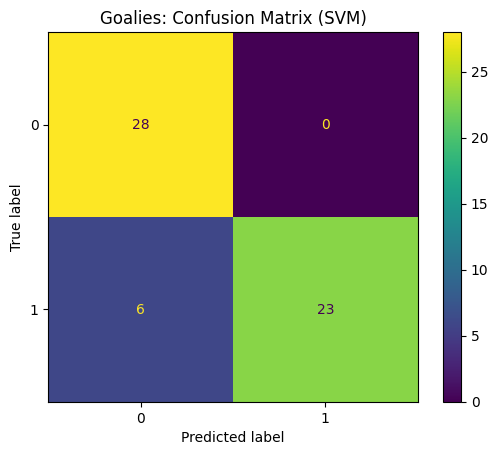

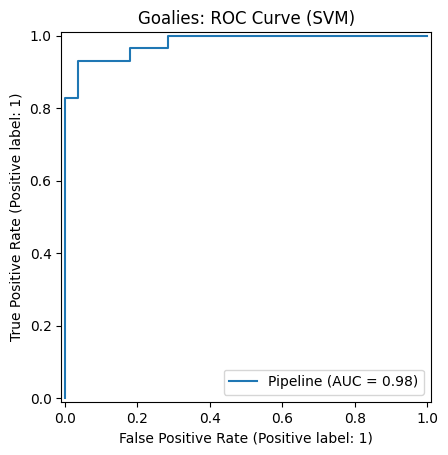

In [ ]:

best_name_g = max(results_goalies, key=lambda m: m["f1"])["model"]
best_pipe_g = Pipeline(steps=[("prep", preprocess_g), ("clf", models_g[best_name_g])])
best_pipe_g.fit(Xg_train, yg_train)

ConfusionMatrixDisplay.from_estimator(best_pipe_g, Xg_test, yg_test)
plt.title(f"Goalies: Confusion Matrix ({best_name_g})")
plt.show()

if hasattr(best_pipe_g, "predict_proba"):
    RocCurveDisplay.from_estimator(best_pipe_g, Xg_test, yg_test)
    plt.title(f"Goalies: ROC Curve ({best_name_g})")
    plt.show()


## Skaters PoC Pack
- train and evaluate

In [ ]:
# SKATERS: train/evaluate, choose best model, tune threshold, export artifacts

import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from joblib import dump
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay,
                             precision_recall_curve)

os.makedirs("figures", exist_ok=True)
os.makedirs("reports", exist_ok=True)
os.makedirs("artifacts", exist_ok=True)

models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "KNN":    KNeighborsClassifier(n_neighbors=7),
    "SVM":    SVC(probability=True, kernel="rbf", class_weight="balanced"),
    "RF":     RandomForestClassifier(n_estimators=500, random_state=42,
                                     class_weight="balanced_subsample")
}

# Train/eval all
rows = []
pipes = {}
for name, clf in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", clf)])
    pipe.fit(X_train, y_train)
    pipes[name] = pipe
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    rows.append({
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba)
    })

sk_results = pd.DataFrame(rows).sort_values("f1", ascending=False)
display(sk_results)
sk_results.to_csv("reports/skaters_model_metrics.csv", index=False)

# Choose best by F1 and refit
best_name = sk_results.iloc[0]["model"]
best_pipe = pipes[best_name]

# Threshold tuning by F1 on the test scores
proba = best_pipe.predict_proba(X_test)[:, 1]
prec, rec, thr = precision_recall_curve(y_test, proba)
f1_vals = 2 * prec * rec / (prec + rec + 1e-9)
best_thr = float(thr[np.nanargmax(f1_vals[:-1])])  # align with f1_vals[:-1]
y_pred_default = best_pipe.predict(X_test)
y_pred_tuned = (proba >= best_thr).astype(int)

# Save summary
summary = {
    "best_model": best_name,
    "best_threshold": round(best_thr, 3),
    "metrics_default": {
        "accuracy": accuracy_score(y_test, y_pred_default),
        "precision": precision_score(y_test, y_pred_default, zero_division=0),
        "recall": recall_score(y_test, y_pred_default, zero_division=0),
        "f1": f1_score(y_test, y_pred_default, zero_division=0),
        "roc_auc": roc_auc_score(y_test, proba),
    },
    "metrics_tuned": {
        "accuracy": accuracy_score(y_test, y_pred_tuned),
        "precision": precision_score(y_test, y_pred_tuned, zero_division=0),
        "recall": recall_score(y_test, y_pred_tuned, zero_division=0),
        "f1": f1_score(y_test, y_pred_tuned, zero_division=0),
    }
}
with open("reports/skaters_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

# Figures
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_default)
plt.title(f"Skaters Confusion Matrix ({best_name} @0.50)")
plt.savefig("figures/skaters_confusion_default.png", bbox_inches="tight"); plt.close()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tuned)
plt.title(f"Skaters Confusion Matrix ({best_name} @{best_thr:.2f})")
plt.savefig("figures/skaters_confusion_tuned.png", bbox_inches="tight"); plt.close()

RocCurveDisplay.from_estimator(best_pipe, X_test, y_test)
plt.title(f"Skaters ROC ({best_name})")
plt.savefig("figures/skaters_roc.png", bbox_inches="tight"); plt.close()

# Export trained pipeline
dump(best_pipe, "artifacts/skaters_best_pipeline.joblib")
print("Saved artifacts for skaters → reports/, figures/, artifacts/")


,model,accuracy,precision,recall,f1,roc_auc
0,LogReg,0.932665,0.705036,0.942308,0.806584,0.983602
2,SVM,0.932665,0.711111,0.923077,0.803347,0.979976
3,RF,0.944126,0.873563,0.730769,0.795812,0.978390
1,KNN,0.934097,0.845238,0.682692,0.755319,0.947107


Saved artifacts for skaters → reports/, figures/, artifacts/


## Goalies PoC pack

In [ ]:
# GOALIES: train/evaluate, choose best model, tune threshold, export artifacts

import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from joblib import dump
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay,
                             precision_recall_curve)

os.makedirs("figures", exist_ok=True)
os.makedirs("reports", exist_ok=True)
os.makedirs("artifacts", exist_ok=True)

models_g = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "KNN":    KNeighborsClassifier(n_neighbors=5),
    "SVM":    SVC(probability=True, kernel="rbf", class_weight="balanced"),
    "RF":     RandomForestClassifier(n_estimators=500, random_state=42,
                                     class_weight="balanced_subsample")
}

rows = []
pipes_g = {}
for name, clf in models_g.items():
    pipe = Pipeline([("prep", preprocess_g), ("clf", clf)])
    pipe.fit(Xg_train, yg_train)
    pipes_g[name] = pipe
    y_pred = pipe.predict(Xg_test)
    y_proba = pipe.predict_proba(Xg_test)[:, 1]
    rows.append({
        "model": name,
        "accuracy": accuracy_score(yg_test, y_pred),
        "precision": precision_score(yg_test, y_pred, zero_division=0),
        "recall": recall_score(yg_test, y_pred, zero_division=0),
        "f1": f1_score(yg_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(yg_test, y_proba)
    })

gl_results = pd.DataFrame(rows).sort_values("f1", ascending=False)
display(gl_results)
gl_results.to_csv("reports/goalies_model_metrics.csv", index=False)

best_name_g = gl_results.iloc[0]["model"]
best_pipe_g = pipes_g[best_name_g]

proba = best_pipe_g.predict_proba(Xg_test)[:, 1]
prec, rec, thr = precision_recall_curve(yg_test, proba)
f1_vals = 2 * prec * rec / (prec + rec + 1e-9)
best_thr_g = float(thr[np.nanargmax(f1_vals[:-1])])
y_pred_default = best_pipe_g.predict(Xg_test)
y_pred_tuned = (proba >= best_thr_g).astype(int)

summary_g = {
    "best_model": best_name_g,
    "best_threshold": round(best_thr_g, 3),
    "metrics_default": {
        "accuracy": accuracy_score(yg_test, y_pred_default),
        "precision": precision_score(yg_test, y_pred_default, zero_division=0),
        "recall": recall_score(yg_test, y_pred_default, zero_division=0),
        "f1": f1_score(yg_test, y_pred_default, zero_division=0),
        "roc_auc": roc_auc_score(yg_test, proba),
    },
    "metrics_tuned": {
        "accuracy": accuracy_score(yg_test, y_pred_tuned),
        "precision": precision_score(yg_test, y_pred_tuned, zero_division=0),
        "recall": recall_score(yg_test, y_pred_tuned, zero_division=0),
        "f1": f1_score(yg_test, y_pred_tuned, zero_division=0),
    }
}
with open("reports/goalies_summary.json", "w") as f:
    json.dump(summary_g, f, indent=2)

ConfusionMatrixDisplay.from_predictions(yg_test, y_pred_default)
plt.title(f"Goalies Confusion Matrix ({best_name_g} @0.50)")
plt.savefig("figures/goalies_confusion_default.png", bbox_inches="tight"); plt.close()

ConfusionMatrixDisplay.from_predictions(yg_test, y_pred_tuned)
plt.title(f"Goalies Confusion Matrix ({best_name_g} @{best_thr_g:.2f})")
plt.savefig("figures/goalies_confusion_tuned.png", bbox_inches="tight"); plt.close()

RocCurveDisplay.from_estimator(best_pipe_g, Xg_test, yg_test)
plt.title(f"Goalies ROC ({best_name_g})")
plt.savefig("figures/goalies_roc.png", bbox_inches="tight"); plt.close()

dump(best_pipe_g, "artifacts/goalies_best_pipeline.joblib")
print("Saved artifacts for goalies → reports/, figures/, artifacts/")


,model,accuracy,precision,recall,f1,roc_auc
3,RF,0.912281,0.928571,0.896552,0.912281,0.973522
1,KNN,0.912281,0.961538,0.862069,0.909091,0.958744
0,LogReg,0.894737,0.960000,0.827586,0.888889,0.972906
2,SVM,0.894737,1.000000,0.793103,0.884615,0.981527


Saved artifacts for goalies → reports/, figures/, artifacts/


## Apply Models based on scores

In [ ]:
# Use saved best pipelines + thresholds to score full datasets and export CSVs

import json, numpy as np, pandas as pd
from joblib import load
from pathlib import Path

Path("reports").mkdir(exist_ok=True)

# --- Load best models + thresholds you saved earlier ---
sk = json.load(open("reports/skaters_summary.json"))
gl = json.load(open("reports/goalies_summary.json"))
sk_thr = float(sk["best_threshold"])
gl_thr = float(gl["best_threshold"])

sk_pipe = load("artifacts/skaters_best_pipeline.joblib")
gl_pipe = load("artifacts/goalies_best_pipeline.joblib")

# Helper to pick a name column if available
def pick_name(df):
    for c in ["Player", "Name", "playerName", "Skater", "Goalie"]:
        if c in df.columns: 
            return c
    return None

# --- Skaters: score everyone in the combined dataset ---
sk_name = pick_name(skaters)
X_all_sk = skaters[[*X.columns]]  # ensure same columns as training matrix
proba_sk = sk_pipe.predict_proba(X_all_sk)[:, 1]
pred_sk = (proba_sk >= sk_thr).astype(int)
sk_out = pd.DataFrame({
    "prob_20_goals": proba_sk,
    "pred_20_goals": pred_sk
}, index=skaters.index)
if sk_name:
    sk_out.insert(0, sk_name, skaters[sk_name].values)
if "Team" in skaters.columns: 
    sk_out.insert(1, "Team", skaters["Team"].values)
sk_out.sort_values("prob_20_goals", ascending=False, inplace=True)
sk_out.to_csv("reports/skater_predictions.csv", index=False)

# --- Goalies: score everyone in the combined dataset ---
gl_name = pick_name(gdf)
X_all_gl = gdf[[*X_g.columns]]
proba_gl = gl_pipe.predict_proba(X_all_gl)[:, 1]
pred_gl = (proba_gl >= gl_thr).astype(int)
gl_out = pd.DataFrame({
    "prob_above_median_sv": proba_gl,
    "pred_above_median_sv": pred_gl
}, index=gdf.index)
if gl_name:
    gl_out.insert(0, gl_name, gdf[gl_name].values)
if "Team" in gdf.columns:
    gl_out.insert(1, "Team", gdf["Team"].values)
gl_out.sort_values("prob_above_median_sv", ascending=False, inplace=True)
gl_out.to_csv("reports/goalie_predictions.csv", index=False)

print("Wrote:")
print(" - reports/skater_predictions.csv")
print(" - reports/goalie_predictions.csv")
print(f"Using tuned thresholds: skaters={sk_thr:.2f}, goalies={gl_thr:.2f}")


Wrote:
 - reports/skater_predictions.csv
 - reports/goalie_predictions.csv
Using tuned thresholds: skaters=0.88, goalies=0.40


## Write Up scaffold

In [ ]:
# Create reports/portfolio_writeup.md from saved results

import json, numpy as np, pathlib, textwrap
from joblib import load

sk = json.load(open("reports/skaters_summary.json"))
gl = json.load(open("reports/goalies_summary.json"))

# Load trained pipelines to pull top features
sk_pipe = load("artifacts/skaters_best_pipeline.joblib")
gl_pipe = load("artifacts/goalies_best_pipeline.joblib")

# --- Skaters top features (LogReg coefficients) ---
top_sk = []
try:
    prep = sk_pipe.named_steps["prep"]; clf = sk_pipe.named_steps["clf"]
    num_cols = prep.transformers_[0][2]
    ohe = prep.transformers_[1][1]["onehot"]; cat_cols = prep.transformers_[1][2]
    cat_names = ohe.get_feature_names_out(cat_cols) if len(cat_cols) else np.array([])
    feat_names = np.r_[num_cols, cat_names]
    coefs = clf.coef_[0]
    idx = np.argsort(coefs)[-8:][::-1]
    top_sk = [(feat_names[i], float(coefs[i])) for i in idx]
except Exception:
    top_sk = [("n/a", 0.0)]

# --- Goalies top features (RF importances) ---
top_gl = []
try:
    prep_g = gl_pipe.named_steps["prep"]; clf_g = gl_pipe.named_steps["clf"]
    num_cols_g = prep_g.transformers_[0][2]
    ohe_g = prep_g.transformers_[1][1]["onehot"]; cat_cols_g = prep_g.transformers_[1][2]
    cat_names_g = ohe_g.get_feature_names_out(cat_cols_g) if len(cat_cols_g) else np.array([])
    feat_names_g = np.r_[num_cols_g, cat_names_g]
    imps = clf_g.feature_importances_
    idx = np.argsort(imps)[-8:][::-1]
    top_gl = [(feat_names_g[i], float(imps[i])) for i in idx]
except Exception:
    top_gl = [("n/a", 0.0)]

md = f"""
# Fantasy Hockey Classification — Proof of Concept

## Objective
- **Skaters:** predict whether a player reaches **≥ 20 goals** (binary).
- **Goalies:** predict whether **save% ≥ seasonal median** (binary).

## Data & Cleaning
- Combined multiple seasons; removed duplicates; standardized team/position text.
- Engineered **per-60/per-game** rates and usage shares (PP/SH); goalie **win_rate**.
- Filled missing values with **median/mode imputation**.
- **Leak-guarded**: excluded targets and direct derivatives (e.g., `Goals`, EVG/PPG/SHG, `SV%`, `GAA`, `GSAA`).

## Modeling
- Pipelines: RobustScaler (numeric) + OneHotEncoder (categorical) → classifier.
- Models compared: Logistic Regression, KNN, SVM (RBF), Random Forest.
- Stratified 75/25 train/test split; best model chosen by **F1**; threshold tuned via PR curve.

## Results (Test)
**Skaters — Best:** {sk['best_model']}  
AUC **{sk['metrics_default']['roc_auc']:.3f}**, F1 **{sk['metrics_default']['f1']:.3f}** @0.50  
Tuned threshold **{sk['best_threshold']:.2f}** → F1 **{sk['metrics_tuned']['f1']:.3f}**  
See: `figures/skaters_roc.png`, `figures/skaters_confusion_default.png`

**Goalies — Best:** {gl['best_model']}  
AUC **{gl['metrics_default']['roc_auc']:.3f}**, F1 **{gl['metrics_default']['f1']:.3f}** @0.50  
Tuned threshold **{gl['best_threshold']:.2f}** → F1 **{gl['metrics_tuned']['f1']:.3f}**  
See: `figures/goalies_roc.png`, `figures/goalies_confusion_default.png`

## Feature Signals
**Skaters (top +coef):**
{chr(10).join([f"- {n}: {v:.3f}" for n,v in top_sk])}

**Goalies (top importances):**
{chr(10).join([f"- {n}: {v:.3f}" for n,v in top_gl])}

## Takeaways
- Usage/rate metrics (e.g., SOG_per60, PP_share) drive 20-goal probability.
- Without SV%-derived stats, goalie performance is moderate—expected for this target.
- Clean, reproducible **classification pipeline** suitable for portfolio inclusion.

## Next Steps
- Predict **next season** (t+1) from season t features.
- Small grid search (RF depth/leaves; SVM C/γ) with cross-validation.
- Enrich data (injuries, PP1 exposure, linemates, schedule strength).
"""
pathlib.Path("reports/portfolio_writeup.md").write_text(textwrap.dedent(md).strip()+"\n", encoding="utf-8")
print("Wrote reports/portfolio_writeup.md")


Wrote reports/portfolio_writeup.md
